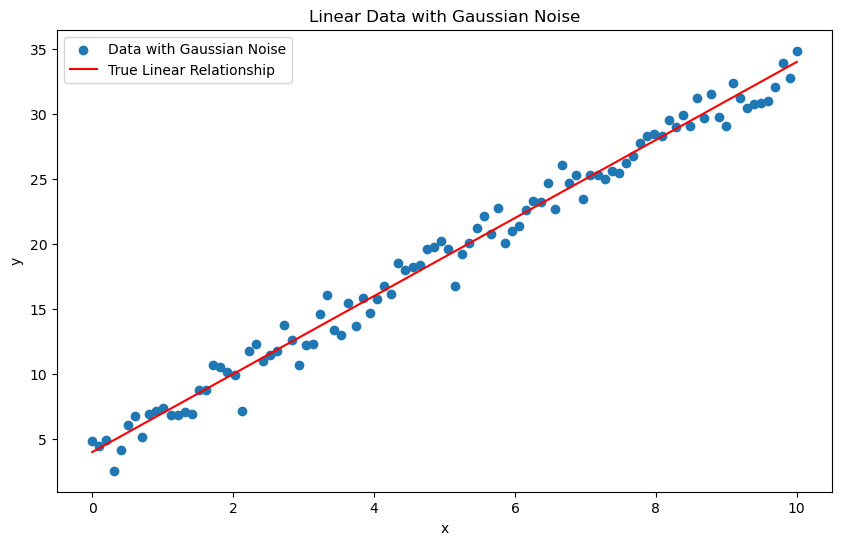

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Parameters for linear data
slope = 3
intercept = 4
n_points = 100

# Generate linear data
x = np.linspace(0, 10, n_points)
y_true = slope * x + intercept

# Add Gaussian noise
np.random.seed(20)
noise = np.random.normal(0, 1, n_points)
y_noisy = y_true + noise

# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(x, y_noisy, label='Data with Gaussian Noise')
plt.plot(x, y_true, color='red', label='True Linear Relationship')
plt.title('Linear Data with Gaussian Noise')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [12]:
def log_likelihood(slope, intercept, x, y, sigma=1):
    """ Computes the log likelihood for linear regression """
    y_pred = slope * x + intercept
    return -0.5 * np.sum(((y - y_pred) / sigma) ** 2)

def log_posterior(slope, intercept, x, y):
    """ Computes the log posterior, with a flat prior """
    return log_likelihood(slope, intercept, x, y)



## Hamiltonian Monte-Carlo

In [13]:
def analytical_gradients(slope, intercept, x, y):
    """ Calculate the analytical gradients of the log-likelihood """
    d_log_likelihood_slope = np.sum((y - (slope * x + intercept)) * x)
    d_log_likelihood_intercept = np.sum(y - (slope * x + intercept))
    return d_log_likelihood_slope, d_log_likelihood_intercept

def hmc(n_samples, step_size, n_leapfrog, x, y):
    # Starting values for slope and intercept
    slope = 0
    intercept = 0

    # Arrays to store samples
    slope_samples = []
    intercept_samples = []

    # Acceptance rate tracking
    accept_count = 0

    for _ in range(n_samples):
        # Current position and momentum
        current_slope = slope
        current_intercept = intercept
        current_momentum_slope = np.random.normal()
        current_momentum_intercept = np.random.normal()

        # Simulate dynamics
        new_slope = current_slope
        new_intercept = current_intercept
        new_momentum_slope = current_momentum_slope
        new_momentum_intercept = current_momentum_intercept

        # Leapfrog integration
        for _ in range(n_leapfrog):
            # Update momentum by half step
            grad_slope, grad_intercept = analytical_gradients(new_slope, new_intercept, x, y)
            new_momentum_slope += 0.5 * step_size * grad_slope
            new_momentum_intercept += 0.5 * step_size * grad_intercept

            # Update position by full step
            new_slope += step_size * new_momentum_slope
            new_intercept += step_size * new_momentum_intercept

            # Update momentum by another half step
            grad_slope, grad_intercept = analytical_gradients(new_slope, new_intercept, x, y)
            new_momentum_slope += 0.5 * step_size * grad_slope
            new_momentum_intercept += 0.5 * step_size * grad_intercept

        # Metropolis acceptance criterion
        current_U = -log_likelihood(current_slope, current_intercept, x, y)
        current_K = 0.5 * (current_momentum_slope**2 + current_momentum_intercept**2)
        proposed_U = -log_likelihood(new_slope, new_intercept, x, y)
        proposed_K = 0.5 * (new_momentum_slope**2 + new_momentum_intercept**2)

        if np.random.rand() < np.exp(current_U - proposed_U + current_K - proposed_K):
            slope = new_slope
            intercept = new_intercept
            accept_count += 1

        slope_samples.append(slope)
        intercept_samples.append(intercept)

    acceptance_rate = accept_count / n_samples
    return slope_samples, intercept_samples, acceptance_rate

# Perform HMC sampling with analytical gradients
n_samples = 10000
step_size = 0.01
n_leapfrog = 10

slope_samples, intercept_samples, acceptance_rate = hmc(n_samples, step_size, n_leapfrog, x, y_noisy)
acceptance_rate


0.9912

In [14]:
burnin = 1000
slope_samples, intercept_samples = slope_samples[burnin:], intercept_samples[burnin:]

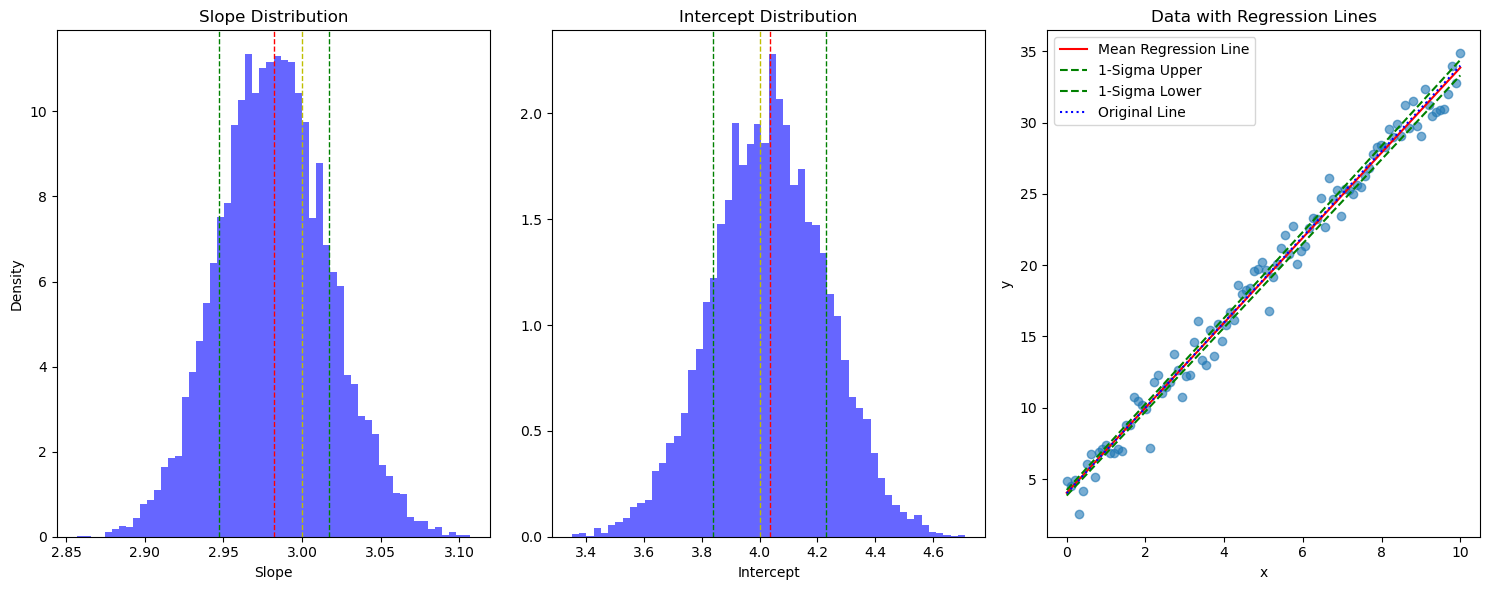

In [15]:
# Plotting the actual distributions of slope and intercept along with the input values and 1-sigma lines

# Calculate the mean and standard deviation for slope and intercept samples
mean_slope = np.mean(slope_samples)
std_slope = np.std(slope_samples)
mean_intercept = np.mean(intercept_samples)
std_intercept = np.std(intercept_samples)

# Generate lines for mean and 1-sigma
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line_mean = mean_slope * x_line + mean_intercept
y_line_upper = (mean_slope + std_slope) * x_line + (mean_intercept + std_intercept)
y_line_lower = (mean_slope - std_slope) * x_line + (mean_intercept - std_intercept)

# Adding the input line (original true line)

# Original true line based on the input values of slope and intercept
original_slope = 3
original_intercept = 4
y_original_line = original_slope * x_line + original_intercept

# Plotting the slope and intercept distributions
plt.figure(figsize=(15, 6))

# Slope distribution
plt.subplot(1, 3, 1)
plt.hist(slope_samples, bins="auto", density=True, alpha=0.6, color='blue')
plt.axvline(mean_slope, color='red', linestyle='dashed', linewidth=1)
plt.axvline(original_slope, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mean_slope + std_slope, color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean_slope - std_slope, color='green', linestyle='dashed', linewidth=1)
plt.title('Slope Distribution')
plt.xlabel('Slope')
plt.ylabel('Density')

# Intercept distribution
plt.subplot(1, 3, 2)
plt.hist(intercept_samples, bins="auto", density=True, alpha=0.6, color='blue')
plt.axvline(mean_intercept, color='red', linestyle='dashed', linewidth=1)
plt.axvline(original_intercept, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mean_intercept + std_intercept, color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean_intercept - std_intercept, color='green', linestyle='dashed', linewidth=1)
plt.title('Intercept Distribution')
plt.xlabel('Intercept')

# Data with 1-sigma lines
plt.subplot(1, 3, 3)
plt.scatter(x, y_noisy, alpha=0.6)
plt.plot(x_line, y_line_mean, color='red', label='Mean Regression Line')
plt.plot(x_line, y_line_upper, color='green', linestyle='dashed', label='1-Sigma Upper')
plt.plot(x_line, y_line_lower, color='green', linestyle='dashed', label='1-Sigma Lower')
plt.plot(x_line, y_original_line, color='blue', linestyle='dotted', label='Original Line')
plt.title('Data with Regression Lines')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()



/Users/sayan/anaconda3/envs/clusterlens/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/sayan/anaconda3/envs/clusterlens/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/sayan/anaconda3/envs/clusterlens/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


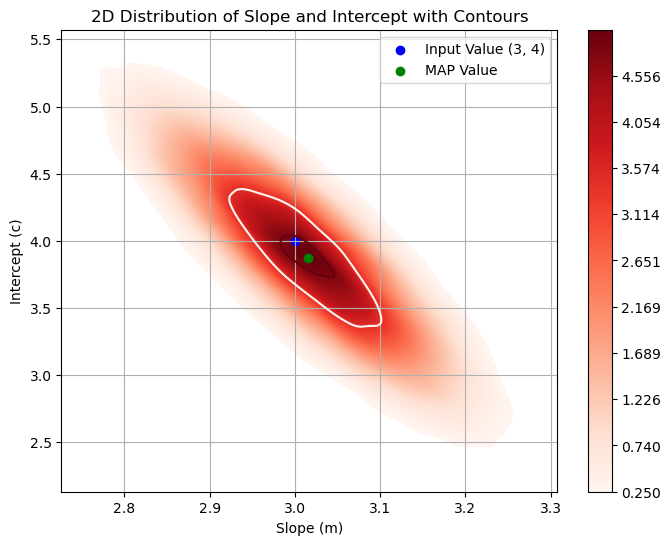

In [12]:
map_index = np.argmax([log_posterior(slope, intercept, x, y_noisy) for slope, intercept in zip(slope_samples, intercept_samples)])
map_slope = slope_samples[map_index]
map_intercept = intercept_samples[map_index]
x_lim = (mean_slope - 3*std_slope, mean_slope + 3*std_slope)
y_lim = (mean_intercept - 3*std_intercept, mean_intercept + 3*std_intercept)


# Adjusting the KDE plot for a smoother color gradient and adding contours on top
plt.figure(figsize=(8, 6))
sns.kdeplot(slope_samples, intercept_samples, cmap="Reds", shade=True, shade_lowest=False, n_levels=1000, cbar=True)
sns.kdeplot(slope_samples, intercept_samples, cmap="Reds", levels=[0.683, 0.954], color='black')
plt.scatter([3], [4], color='blue', label='Input Value (3, 4)')  # Input value for slope and intercept
plt.scatter([map_slope], [map_intercept], color='green', label='MAP Value')  # MAP value
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('2D Distribution of Slope and Intercept with Contours')
plt.xlabel('Slope (m)')
plt.ylabel('Intercept (c)')
plt.legend()
plt.grid(True)
plt.show()



## Metropolis-Hastings

In [16]:
def metropolis_hastings(n_samples, x, y):
    """ Metropolis-Hastings algorithm for sampling slope and intercept """
    # Initial guesses for slope and intercept
    slope = 0
    intercept = 0

    # Arrays to store samples
    slope_samples = []
    intercept_samples = []

    # Acceptance rate tracking
    accept_count = 0

    for _ in range(n_samples):
        # Propose new values for slope and intercept
        new_slope = np.random.normal(slope, 0.5)  # Propose a new slope
        new_intercept = np.random.normal(intercept, 0.5)  # Propose a new intercept

        # Calculate acceptance probability
        current_likelihood = log_likelihood(slope, intercept, x, y)
        new_likelihood = log_likelihood(new_slope, new_intercept, x, y)
        acceptance_prob = np.exp(new_likelihood - current_likelihood)

        # Accept or reject the new values
        if np.random.rand() < acceptance_prob:
            slope = new_slope
            intercept = new_intercept
            accept_count += 1

        slope_samples.append(slope)
        intercept_samples.append(intercept)

    acceptance_rate = accept_count / n_samples
    return slope_samples, intercept_samples, acceptance_rate

# Perform Metropolis-Hastings sampling
mh_slope_samples, mh_intercept_samples, mh_acceptance_rate = metropolis_hastings(n_samples, x, y_noisy)


mh_acceptance_rate

/var/folders/lq/txnqg8855_n_tmtdx94sjxjw0000gn/T/ipykernel_9681/588649322.py:22: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.exp(new_likelihood - current_likelihood)


0.0246

In [8]:
mh_slope_samples, mh_intercept_samples = mh_slope_samples[burnin:], mh_intercept_samples[burnin:]

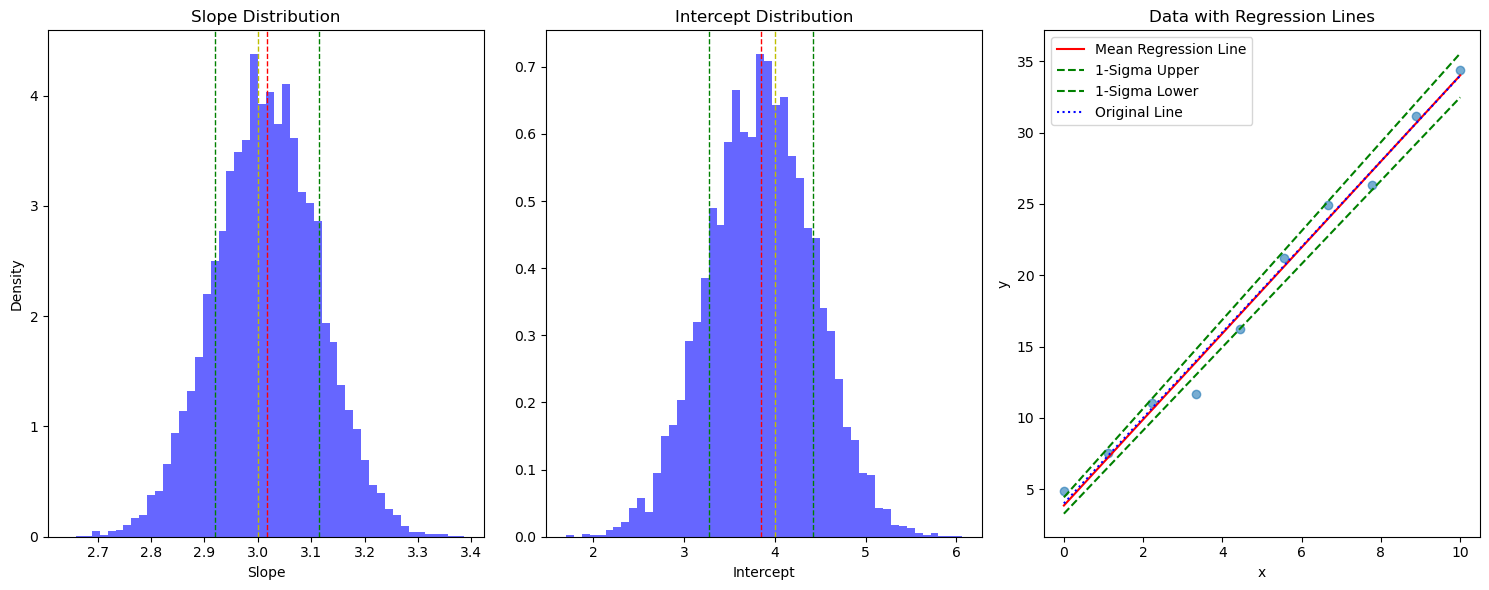

In [9]:
# Plotting the actual distributions of slope and intercept along with the input values and 1-sigma lines

# Calculate the mean and standard deviation for slope and intercept samples
mean_slope = np.mean(mh_slope_samples)
std_slope = np.std(mh_slope_samples)
mean_intercept = np.mean(mh_intercept_samples)
std_intercept = np.std(mh_intercept_samples)

# Generate lines for mean and 1-sigma
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line_mean = mean_slope * x_line + mean_intercept
y_line_upper = (mean_slope + std_slope) * x_line + (mean_intercept + std_intercept)
y_line_lower = (mean_slope - std_slope) * x_line + (mean_intercept - std_intercept)

# Adding the input line (original true line)

# Original true line based on the input values of slope and intercept
original_slope = 3
original_intercept = 4
y_original_line = original_slope * x_line + original_intercept

# Plotting the slope and intercept distributions
plt.figure(figsize=(15, 6))

# Slope distribution
plt.subplot(1, 3, 1)
plt.hist(mh_slope_samples, bins=50, density=True, alpha=0.6, color='blue')
plt.axvline(mean_slope, color='red', linestyle='dashed', linewidth=1)
plt.axvline(original_slope, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mean_slope + std_slope, color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean_slope - std_slope, color='green', linestyle='dashed', linewidth=1)
plt.title('Slope Distribution')
plt.xlabel('Slope')
plt.ylabel('Density')

# Intercept distribution
plt.subplot(1, 3, 2)
plt.hist(mh_intercept_samples, bins=50, density=True, alpha=0.6, color='blue')
plt.axvline(mean_intercept, color='red', linestyle='dashed', linewidth=1)
plt.axvline(original_intercept, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mean_intercept + std_intercept, color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean_intercept - std_intercept, color='green', linestyle='dashed', linewidth=1)
plt.title('Intercept Distribution')
plt.xlabel('Intercept')

# Data with 1-sigma lines
plt.subplot(1, 3, 3)
plt.scatter(x, y_noisy, alpha=0.6)
plt.plot(x_line, y_line_mean, color='red', label='Mean Regression Line')
plt.plot(x_line, y_line_upper, color='green', linestyle='dashed', label='1-Sigma Upper')
plt.plot(x_line, y_line_lower, color='green', linestyle='dashed', label='1-Sigma Lower')
plt.plot(x_line, y_original_line, color='blue', linestyle='dotted', label='Original Line')
plt.title('Data with Regression Lines')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()


/Users/sayan/anaconda3/envs/clusterlens/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/sayan/anaconda3/envs/clusterlens/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/Users/sayan/anaconda3/envs/clusterlens/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


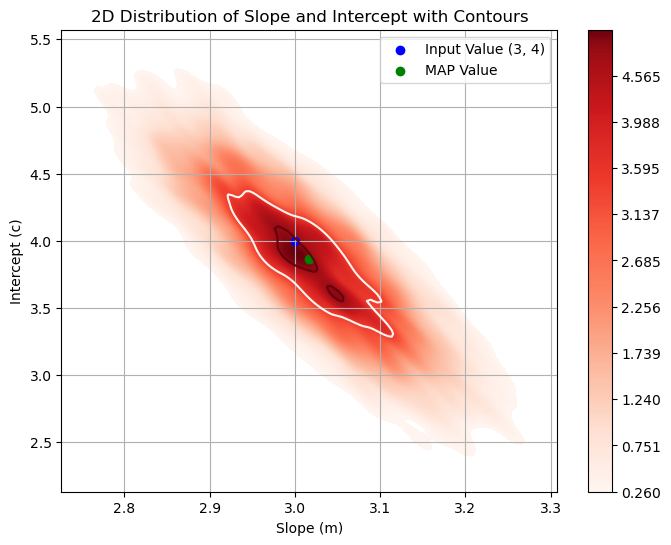

In [11]:
map_index = np.argmax([log_posterior(slope, intercept, x, y_noisy) for slope, intercept in zip(mh_slope_samples, mh_intercept_samples)])
map_slope = mh_slope_samples[map_index]
map_intercept = mh_intercept_samples[map_index]
x_lim = (mean_slope - 3*std_slope, mean_slope + 3*std_slope)
y_lim = (mean_intercept - 3*std_intercept, mean_intercept + 3*std_intercept)


# Adjusting the KDE plot for a smoother color gradient and adding contours on top
plt.figure(figsize=(8, 6))
sns.kdeplot(mh_slope_samples, mh_intercept_samples, cmap="Reds", shade=True, shade_lowest=False, n_levels=1000, cbar=True)
sns.kdeplot(mh_slope_samples, mh_intercept_samples, cmap="Reds", levels=[0.683, 0.954], color='black')
plt.scatter([3], [4], color='blue', label='Input Value (3, 4)')  # Input value for slope and intercept
plt.scatter([map_slope], [map_intercept], color='green', label='MAP Value')  # MAP value
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('2D Distribution of Slope and Intercept with Contours')
plt.xlabel('Slope (m)')
plt.ylabel('Intercept (c)')
plt.legend()
plt.grid(True)
plt.show()